In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

Question 1: Modeling volatility
Find data for historical prices for any publicly traded equity. To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness.

In [67]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-09-29 00:00:00-04:00,431.670013,431.850006,425.910004,427.480011,115078500,0.0,0.0,0.0
2023-10-02 00:00:00-04:00,426.619995,428.600006,424.459991,427.309998,83798600,0.0,0.0,0.0
2023-10-03 00:00:00-04:00,425.059998,427.369995,420.179993,421.589996,103760600,0.0,0.0,0.0
2023-10-04 00:00:00-04:00,422.070007,425.429993,420.559998,424.660004,87372400,0.0,0.0,0.0
2023-10-05 00:00:00-04:00,422.070007,425.260010,423.540009,423.890015,5861106,0.0,0.0,0.0


1. Geometric Brownian motion

$\frac{lnS(t_i)-lnS(t_{i-1})}{\sqrt{\Delta t}}= (\mu-\frac{1}{2}\sigma^2)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}}$

In [70]:
y = np.log(df.Close/df.Close.shift(1))*np.sqrt(252)

In [71]:
#historic volatility
hv = y.std()
hv

0.21586925458831768

$ s^2 = \frac{1}{N-1} (\sum_{i=1}^{N}y_i^2-N\overline{y}^2)  $

In [73]:
np.sqrt(((y**2).sum()-len(y)*y.mean()**2)/(len(y)-1))

0.2157833055470414

2. Any non-constant volatility model

Text(0, 0.5, 'volatility')

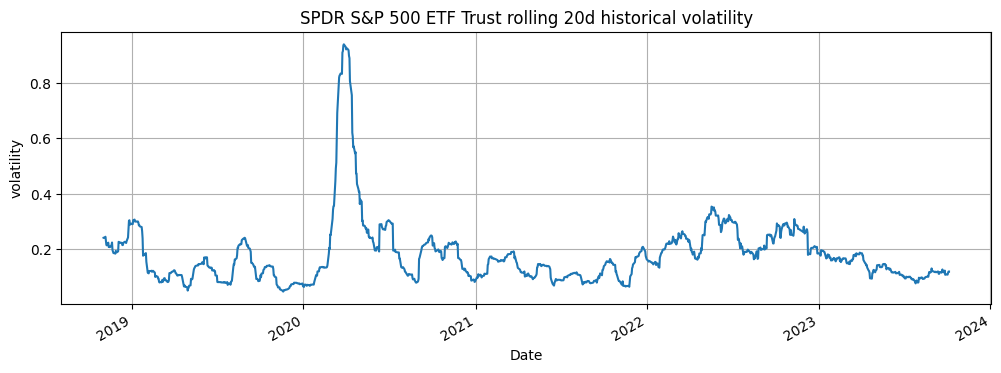

In [74]:
# rolling 20d historic volatility
ax = (y.rolling(20).std()).plot(figsize=(12,4),grid=True,title=spy.info['longName']+' rolling 20d historical volatility')
ax.set_ylabel('volatility')

In [93]:
#EWMA volatility model
vol0 = y[:21].std()
decay = 0.9
ewma_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    ewma_vol.iloc[i] = (1-decay)*y.iloc[i-1]**2 + decay*vol0**2
    vol0 =  ewma_vol.iloc[i]
ewma_vol = np.sqrt(ewma_vol)


Text(0, 0.5, 'volatility')

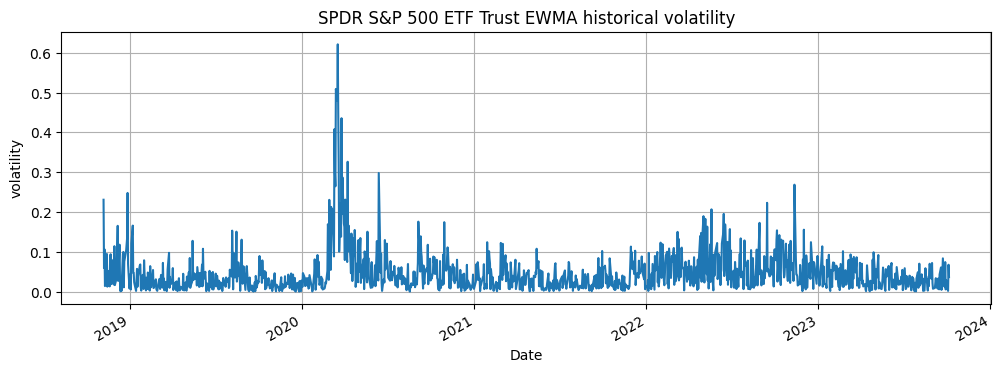

In [95]:
ax = ewma_vol.plot(figsize=(12,4),grid=True,title=spy.info['longName']+' EWMA historical volatility')
ax.set_ylabel('volatility')

GARCH Model

$y_i=\frac{lnS(t_i)-lnS(t_{i-1})-(\mu-\frac{1}{2}\sigma_i^2)\Delta t}{\sqrt{\Delta t}} \quad \text{follows} \quad N(0,\sigma_i^2)$

3. Show volatility smile

In [62]:
us3m_bond = yf.Ticker('^IRX')

In [66]:
us3m_bond.history(period="1mo")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-05 00:00:00-04:00,5.273,5.285,5.248,5.278,0,0.0,0.0
2023-09-06 00:00:00-04:00,5.308,5.310,5.200,5.300,0,0.0,0.0
2023-09-07 00:00:00-04:00,5.293,5.293,5.283,5.283,0,0.0,0.0
2023-09-08 00:00:00-04:00,5.283,5.293,5.275,5.293,0,0.0,0.0
2023-09-11 00:00:00-04:00,5.288,5.300,5.288,5.293,0,0.0,0.0
2023-09-12 00:00:00-04:00,5.305,5.308,5.305,5.305,0,0.0,0.0
2023-09-13 00:00:00-04:00,5.313,5.315,5.268,5.305,0,0.0,0.0
2023-09-14 00:00:00-04:00,5.298,5.305,5.285,5.295,0,0.0,0.0
2023-09-15 00:00:00-04:00,5.298,5.303,5.293,5.298,0,0.0,0.0


In [36]:
pxlast = df.Close.iloc[-1]

In [45]:
calls = spy.option_chain('2025-12-19').calls
puts = spy.option_chain('2025-12-19').puts

In [49]:
calls['moneyness'] = calls['strike']/pxlast
calls = calls.set_index('moneyness')

puts['moneyness'] = puts['strike']/pxlast
puts = puts.set_index('moneyness')

In [50]:
otmcalls_iv = calls[calls.index>1]['impliedVolatility']
otmputs_iv = puts[puts.index<=1]['impliedVolatility']

In [54]:
iv_curve = pd.concat([otmputs_iv,otmcalls_iv])

In [57]:
iv_curve[0.8:1.2]

moneyness
0.800641    0.031260
0.812415    0.031260
0.824189    0.031260
0.835963    0.031260
0.847737    0.031260
0.859511    0.015635
0.871285    0.015635
0.883059    0.015635
0.894834    0.015635
0.906608    0.015635
0.918382    0.015635
0.930156    0.007822
0.941930    0.007822
0.953704    0.007822
0.965478    0.003916
0.977252    0.003916
0.989027    0.001963
1.000801    0.000132
1.012575    0.001963
1.024349    0.003916
1.036123    0.003916
1.047897    0.007822
1.059671    0.007822
1.071445    0.007822
1.083220    0.015635
1.094994    0.015635
1.106768    0.015635
1.118542    0.015635
1.130316    0.015635
1.142090    0.015635
1.153864    0.015635
1.165638    0.015635
1.177413    0.015635
1.189187    0.031260
Name: impliedVolatility, dtype: float64